# Search engines

This notebook shows how to use [PyTerrier](https://github.com/terrier-org/pyterrier) on the [CORD19 corpus](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7251955/).
Hereafter we are going to see how to:
- index a collection
- access an index
- search an index
- compare the performances of indexing approaches
- learn ranking
- evaluate ranking

The notebook in mainly based on the tutorials at this [link](https://github.com/terrier-org/cikm2021tutorial/tree/main/notebooks), which are part of the tutorial series "[IR From Bag-of-words to BERT and Beyond through Practical Experiments](https://github.com/terrier-org/cikm2021tutorial/)" created for the [CIKM 2021](https://www.cikm2021.org/).

**Optional for Colab users**

Before starting, we can set up the connection with the Google Dive storage, to keep there our documents.
Just execute the following passages:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make sure that the variable path contains the correct sequence of folders separate by a `'/'` to get to your lecture files

In [6]:
import os

path = '/content/drive/MyDrive/Practical_03__Text-Search/03 - Interacting with Document Search Engines.ipynb'

# Extract directory path
dir_path = os.path.dirname(path)

# Change to the directory
os.chdir(dir_path)
print(os.getcwd())  # Verify the new working directory


/content/drive/MyDrive/Practical_03__Text-Search


## Tools installation and configuration

PyTerrier is a Python framework, but uses the underlying [Terrier information retrieval toolkit](http://terrier.org) for many indexing and retrieval operations. While PyTerrier was new in 2020, Terrier is written in Java and has a long history dating back to 2001. PyTerrier makes it easy to perform IR experiments in Python, but using the mature Terrier platform for the expensive indexing and retrieval operations.

PyTerrier is installed as follows. This might take a few minutes, in the meanwhile you can take a look at [PyTerrier documentation](https://pyterrier.readthedocs.io/en/latest/).

In [7]:
!pip install -q python-terrier==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.3 MB/s eta 0:00:00


The next step is to initialise PyTerrier. This is performed using PyTerrier's `init()` method. The `init()` method is needed as PyTerrier must download Terrier's jar file and start the Java virtual machine. We prevent `init()` from being called more than once by checking `started()`.

In [8]:
import pyterrier as pt

if not pt.started():
  pt.init()

<ipython-input-8-ff2ffbf0b6dd>:3: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
<ipython-input-8-ff2ffbf0b6dd>:4: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


## Introduction to document indexing and searching

Much of PyTerrier's view of the world is wrapped up in Pandas dataframes. Let's consider some textual documents in a dataframe.

We can start importing Pandas, a well known Python library to manage tabular data.
You can find Pandas' documentation at the following [link](https://pandas.pydata.org).


In [9]:
import pandas as pd

We can set the length of the displayed output to avoid truncating too much text

In [10]:
pd.set_option('display.max_colwidth', 150)

### Documents

Finally we can create some sample documents to store in a `DataFrame

In [11]:
#We have 3 data-set in our data-frame.
docs_df = pd.DataFrame(
    [
        ["d1", "This is the first article in my collection of articles."],
        ["d2", "This is another article in my collection."],
        ["d3", "The topic of this third article is unknown."]
    ],
    columns=["docno", "text"]
)
docs_df


,docno,text
0,d1,This is the first article in my collection of articles.
1,d2,This is another article in my collection.
2,d3,The topic of this third article is unknown.


### Indexing

Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents.

In the following cell, we index the dataframe's documents. The index, with all its data structures, is written into a directory that we will call `index_3docs`. You can see it in the Google colab files folder on the left.

In [15]:
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
index_ref = indexer.index(docs_df["text"], docs_df["docno"])
index_ref.toString()
#by using these you can retrieve the index from the document and vice versa

<ipython-input-15-e406ad0a7aaa>:1: DeprecationWarning: Call to deprecated class DFIndexer. (use pt.terrier.IterDictIndexer().index(dataframe.to_dict(orient='records')) instead) -- Deprecated since version 0.11.0.
  indexer = pt.DFIndexer("./index_3docs", overwrite=True)


'./index_3docs/data.properties'

`IndexRef` provides the location where the index is stored. Indeed, we can look in the `index_3docs` directory and see that it has created various files:

In [13]:
!ls -lh index_3docs/

total 9.5K
-rw------- 1 root root    4 Mar  6 13:14 data.direct.bf
-rw------- 1 root root   51 Mar  6 13:14 data.document.fsarrayfile
-rw------- 1 root root    5 Mar  6 13:14 data.inverted.bf
-rw------- 1 root root  516 Mar  6 13:14 data.lexicon.fsomapfile
-rw------- 1 root root  273 Mar  6 13:14 data.lexicon.fsomaphash
-rw------- 1 root root   24 Mar  6 13:14 data.lexicon.fsomapid
-rw------- 1 root root   33 Mar  6 13:14 data.meta-0.fsomapfile
-rw------- 1 root root   24 Mar  6 13:14 data.meta.idx
-rw------- 1 root root   48 Mar  6 13:14 data.meta.zdata
-rw------- 1 root root 4.2K Mar  6 13:14 data.properties


We can now load the index:

In [14]:
index = pt.IndexFactory.of(index_ref)

This is a Terrier index structure, which provides methods such as:
 - `getCollectionStatistics()`
 - `getInvertedIndex()`
 - `getLexicon()`

Note Terrier is written in Java. (Yes, yes... I know... Java... 🤢)
The Javadoc documentation is here:
http://terrier.org/docs/current/javadoc/org/terrier/structures/Index.html

Let's see what is returned by the `CollectionStatistics()` method:

In [16]:
print(index.getCollectionStatistics().toString())

Number of documents: 3
Number of terms: 6
Number of postings: 9
Number of fields: 0
Number of tokens: 10
Field names: []
Positions:   false



Ok, that seems fair – we have 3 documents. But why only 6 terms?
Let's check the [`Lexicon`](http://terrier.org/docs/current/javadoc/org/terrier/structures/Lexicon.html), which is our vocabulary. The `Lexicon` contains a set of terms, so we need to iterate over it:

In [20]:
#Our lexicon has 6 terms.
for kv in index.getLexicon():
    print(kv.getKey(),": ", kv.getValue().toString())

#TF = term frequency, how much the term is repeated in document. if you paty attention our data-frame in cell above, you will find out the "article" repeated 4 times.
#maxTF = the maximum a word is occured in a same document. for example the first line of the word include 2-article in a line.

articl :  term1 Nt=3 TF=4 maxTF=2 @{0 0 0}
collect :  term0 Nt=2 TF=2 maxTF=1 @{0 0 7}
first :  term2 Nt=1 TF=1 maxTF=1 @{0 1 3}
third :  term4 Nt=1 TF=1 maxTF=1 @{0 1 5}
topic :  term3 Nt=1 TF=1 maxTF=1 @{0 2 1}
unknown :  term5 Nt=1 TF=1 maxTF=1 @{0 2 5}


We see the terms and the statistics collected about each.
Note that stopwords were removed and Porter's stemmer has been applied.
Here:
 - `Nt` is the number of unique documents that each term occurs in – this is useful for calculating IDF.
 - `TF` is the total number of occurrences of term in corpus.

Finally, we can use the square bracket notation to lookup terms in the lexicon:


In [21]:
index.getLexicon()["articl"].toString()

'term1 Nt=3 TF=4 maxTF=2 @{0 0 0}'

And we can see how many times this term is used in each document that it occurs in (by iterating over the posting lists):

In [22]:
pointer = index.getLexicon()["articl"]
for posting in index.getInvertedIndex().getPostings(pointer):
    print(f'{posting.toString()} doclen = {posting.getDocumentLength()}')

ID(0) TF(2) doclen = 4
ID(1) TF(1) doclen = 2
ID(2) TF(1) doclen = 4


We can see that `"article"` occurs in each of the three documents.

### Searching an Index

Now that we have indexed our documents, we can run a search over the document collection:

In [25]:
#what is TF-IDF: it is a way of scoring the relevance of a documents w.r.t some particular query. It is a product of two matrix TF * IDF
#Term Frequency (TF): Measures how often a term  t appears in a document d.
#If a word appears frequently in a document, its TF score is high.
#IDF =  to determine how important a word is across a collection of documents (corpus). It helps reduce the weight of common words and emphasize rare but significant words.
query = "articles"
br = pt.BatchRetrieve(index, wmodel="TF_IDF")
br.search(query)

<ipython-input-25-8c3f760e9153>:6: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  br = pt.BatchRetrieve(index, wmodel="TF_IDF")


,qid,docid,docno,rank,score,query
0,1,0,d1,0,0.710059,articles
1,1,1,d2,1,0.652174,articles
2,1,2,d3,2,0.504202,articles


Here we used the TF-IDF weighting formula to rank the results.

The `search()` method returns a dataframe with columns:
 - `qid`: the query identifier
 - `docid`: integer identifier for document
 - `docno`: string identifier for document
 - `rank`: rank position
 - `score`: tf-idf score
 - `query`: the input query

### Multiple searches

We can also run multiple queries at once:

In [23]:
queries = pd.DataFrame([["query1", "articles"], ["query2", "first article"], ["query3", "unknown"]], columns=["qid", "query"])
br(queries)

,qid,docid,docno,rank,score,query
0,query1,0,d1,0,0.710059,articles
1,query1,1,d2,1,0.652174,articles
2,query1,2,d3,2,0.504202,articles
3,query2,0,d1,0,1.718463,first article
4,query2,1,d2,1,0.652174,first article
5,query2,2,d3,2,0.504202,first article
6,query3,2,d3,0,1.008403,unknown


## Working with a real dataset

We'll now load a real dataset of COVID-19 related scientific articles (called CORD19) that is available as an example in PyTerrier

In [26]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')

We just downloaded the data. Now we index and save the dataset.

The CORD19 corpus contains articles about the COVID-19, we are going to retrieve only the abstract of these articles to compose our documents. The indexing will take a while to run since there are almost 200,000 articles.

In [27]:
pt_index_path = './terrier_cord19'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=('docno',))

[INFO] [starting] building docstore
[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b8b7e50a39c6f6bb92e0ef
[INFO] [starting] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv
docs_iter:   0%|                                    | 0/192509 [00:00<?, ?doc/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 0.00/269M [00:00<?, ?B/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 57.3k/269M [00:00<09:38, 465kB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.1%| 246k/269M [00:00<04:38, 964kB/s] 
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.4%| 999k/269M [00:00<01:43, 2.59MB/s]
https://ai2-semanticscholar-cord-1

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

14:58:26.428 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
15:00:03.659 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 54937 empty documents


### Querying the index

Now load the index and print the statistics:

In [28]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 192509
Number of terms: 151235
Number of postings: 11554033
Number of fields: 1
Number of tokens: 17728468
Field names: [abstract]
Positions:   false



Let's run a query:

In [29]:
query = "chemical reactions"

tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
tfidf.search(query)

<ipython-input-29-b8001eb5c564>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")


,qid,docid,docno,rank,score,query
0,1,18717,iavwkdpr,0,11.035982,chemical reactions
1,1,171636,v3blnh02,1,10.329726,chemical reactions
2,1,147193,ei4rb8fr,2,10.317138,chemical reactions
3,1,121217,msdycum2,3,9.653734,chemical reactions
4,1,170863,sj8i9ss2,4,9.500211,chemical reactions
...,...,...,...,...,...,...
995,1,2428,38aabxh1,995,3.790183,chemical reactions
996,1,14752,u709r8ss,996,3.790183,chemical reactions
997,1,20074,wxi1xsbo,997,3.790183,chemical reactions
998,1,117156,ts3obwts,998,3.790183,chemical reactions


Instead of ranking documents by their TF-IDF score, we could also use the BM25 score which is known to produce high quality search results.

In [30]:
query = "chemical reactions"

bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25.search(query)

<ipython-input-30-783309414b14>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index, wmodel="BM25")


,qid,docid,docno,rank,score,query
0,1,18717,iavwkdpr,0,20.011607,chemical reactions
1,1,171636,v3blnh02,1,18.723538,chemical reactions
2,1,147193,ei4rb8fr,2,18.700723,chemical reactions
3,1,121217,msdycum2,3,17.498245,chemical reactions
4,1,170863,sj8i9ss2,4,17.228355,chemical reactions
...,...,...,...,...,...,...
995,1,88455,cuvqym6y,995,6.855393,chemical reactions
996,1,137287,8kfjw8ai,996,6.855393,chemical reactions
997,1,140078,kebvzeg4,997,6.855393,chemical reactions
998,1,148411,hhcfrjrn,998,6.855393,chemical reactions


Note that the first 5 documents in the ranking are the same as they were for TF-IDF.

### Evaluating retrieval

So far, we have been creating search engine models, but we haven't decided if any of them are actually any good. In order to determine how good a ranking is, we need annotations telling us which documents are actually relevant for a particular query.

The CORD19 dataset contains set of queries and relevance assessments (aka qrels)for this purpose.

For historical reasons, the queries are called "topics". Let's have a look at the first 10 queries:

In [31]:
queries = cord19.get_topics(variant='title')
queries.head(10)

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [33.9MB/s]


,qid,query
0,1,coronavirus origin
1,2,coronavirus response to weather changes
2,3,coronavirus immunity
3,4,how do people die from the coronavirus
4,5,animal models of covid 19
5,6,coronavirus test rapid testing
6,7,serological tests for coronavirus
7,8,coronavirus under reporting
8,9,coronavirus in canada
9,10,coronavirus social distancing impact


And the first 10 relevance judgements (called qrels):

In [32]:
qrels = cord19.get_qrels()
qrels.head(10)

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:00] [1.14MB] [8.52MB/s]


,qid,docno,label,iteration
0,1,005b2j4b,2,4.5
1,1,00fmeepz,1,4
2,1,010vptx3,2,0.5
3,1,0194oljo,1,2.5
4,1,021q9884,1,4
5,1,02f0opkr,1,1
6,1,047xpt2c,0,3.5
7,1,04ftw7k9,0,1
8,1,05qglt1f,0,1
9,1,05vx82oo,0,3


We can give a look at the distribution of the relevance scores in the data set. To do so we train the count of occurrences of each label, sort the values by label and plot these values in a bat plot (note the log-scale on the y-axis):

<Axes: xlabel='label'>

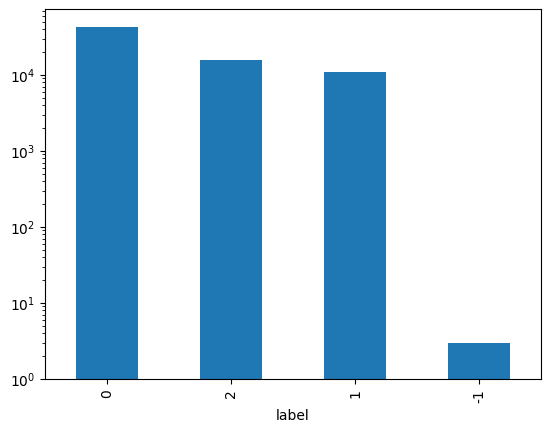

In [33]:
qrels['label'].value_counts().plot(kind='bar', log=True)

Note that there are some relevance judgements taking the value of -1. In the original documentation of the data set (https://ir-datasets.com/cord19.html) only the values 0, 1, and 2 are accepted, so the -1 must be errors in the annotation, since they are only 2 we can drop the corresponding qrels.

To drop the undesired we simply have to retain all the qrels with a label different from -1

In [35]:
qrels = qrels[qrels['label'] != -1]

The qrels contain information on the relevance labels for the query-document pairs. To do our evaluation we need to load also the queries we are going to use to test our retrieval system. For historical reasons, queries are called "topics" in this context.

Let's collect the topics in the CORD-19 corpus:

In [36]:
topics = cord19.get_topics(variant='title')
topics

,qid,query
0,1,coronavirus origin
1,2,coronavirus response to weather changes
2,3,coronavirus immunity
3,4,how do people die from the coronavirus
4,5,animal models of covid 19
5,6,coronavirus test rapid testing
6,7,serological tests for coronavirus
7,8,coronavirus under reporting
8,9,coronavirus in canada
9,10,coronavirus social distancing impact


Now let us use these queries and relevance judgements to compare different retrieval functions to see how well they perform at ranking documents in the collection. We compare BM25 and TF-IDF in terms of two common ranking evaluation measures (MAP and NDCG),
(It evaluates how well a ranking system places highly relevant items earlier in the list.
Unlike simple accuracy metrics, NDCG penalizes incorrect orderings of relevant results.
It is useful in applications like search engines (Google, Bing), recommendation systems (Netflix, Amazon), and machine learning ranking tasks.) where higher values indicate a better ranking:  

In [37]:
pt.Experiment(
    [tfidf, bm25],
    topics,
    qrels,
    eval_metrics=["map", "ndcg"]
)

,name,map,ndcg
0,TerrierRetr(TF_IDF),0.180002,0.370767
1,TerrierRetr(BM25),0.181478,0.373328


More on map and NDCG: https://www.shaped.ai/blog/evaluating-recommendation-systems-map-mmr-ndcg

How were those scores calculated? We can have a look at the score and corresponding relevance labels for individual query document pairs as follows:

In [38]:
# Rank the documents for each query using the TF-IDF scoring function:
results = tfidf(cord19.get_topics(variant='title'))
# Add the relevance labels (qrels) to the table:
results = results.merge(qrels, on=["qid", "docno"], how="left").fillna(0)
# Display the output
results
#label 0 is non-relevant
#label 1 is mostly relevant
#label 2 is maximum relevant

,qid,docid,docno,rank,score,query,label,iteration
0,1,175892,zy8qjaai,0,7.080599,coronavirus origin,1.0,1
1,1,82224,8ccl9aui,1,6.775667,coronavirus origin,2.0,1
2,1,135326,ne5r4d4b,2,6.683114,coronavirus origin,0.0,1.5
3,1,122804,75773gwg,3,6.590340,coronavirus origin,2.0,5
4,1,122805,kn2z7lho,4,6.590340,coronavirus origin,2.0,3
...,...,...,...,...,...,...,...,...
49995,50,133596,hf4hxf9u,995,5.271597,mrna vaccine coronavirus,0.0,0
49996,50,158429,0xf48prl,996,5.271451,mrna vaccine coronavirus,0.0,0
49997,50,277,3gwm1c2f,997,5.270141,mrna vaccine coronavirus,0.0,0
49998,50,10212,o7fv8ww0,998,5.270141,mrna vaccine coronavirus,0.0,0


from matplotlib import pyplot as plt
results['docid'].plot(kind='hist', bins=20, title='docid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['rank'].plot(kind='hist', bins=20, title='rank')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='docid', y='rank', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='rank', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='score', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['docid'].plot(kind='line', figsize=(8, 4), title='docid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['rank'].plot(kind='line', figsize=(8, 4), title='rank')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

## Pipelines

For this part of the notebook, we'll be using the same CORD19.
Differently from before, we are gonna add some columns to our data.

In [39]:
index_ref = indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=('docno', 'abstract', 'title')) ## OLD
index = pt.IndexFactory.of(index_ref)

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pyterrier/terrier/index.py:619: UserWarning: Indexing meta key abstract length requested 512 but exceeded in first document (actual length 1847). Increase the length in the meta dict for the indexer, e.g., pt.IterDictIndexer(..., meta={'abstract': 1847}).
  warn(msg)


15:45:21.294 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
15:47:00.773 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 54937 empty documents


Note: besides the docno, I am specify to output also the text of the abstract and the title of the document in the metadata field. This will be helpful later.

#### Operators

`BatchRetrieve` objects can be combined using some special operators. These combinations are called pipelines.

Hereafter we are going to see three operators:
- Composition
- Rank cut-off
- Union

Before moving to the actual operators we define three retrievers using the index we have just created. We are going to define retrievers using
- TF
- TF-IDF
- BM25

In [40]:
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

<ipython-input-40-7c45dbbc05e4>:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tf = pt.BatchRetrieve(index, wmodel="Tf")
<ipython-input-40-7c45dbbc05e4>:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
<ipython-input-40-7c45dbbc05e4>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index, wmodel="BM25")


##### Composition

The first operator we are going to see is the composition. This operator allow to re-rank the output of one retriever using a second retriever.

To use it, we simply need to compose two retrievers using the  `>>` operator.

Given the first query in the topics we loaded before

In [41]:
query = 'chemical'

Let's see first what TF alone would retrieve

In [42]:
tf.search(query)

,qid,docid,docno,rank,score,query
0,1,37771,jn5qi1jb,0,9.0,chemical
1,1,134305,0smev8vt,1,8.0,chemical
2,1,2524,ifebw24e,2,7.0,chemical
3,1,142053,km3bvc8h,3,7.0,chemical
4,1,142104,77c9ohxj,4,7.0,chemical
...,...,...,...,...,...,...
995,1,62533,5kroa3lw,995,1.0,chemical
996,1,62548,cw4gxbn5,996,1.0,chemical
997,1,62658,bhf3w4qp,997,1.0,chemical
998,1,62708,6kakhjmy,998,1.0,chemical


Now let's compose the TF with the BM25, in this way we will re-rank the TF results using BM25.

First we create a composition an then run the search using the composition pipeline.

In [43]:
composition = tf >> bm25

composition.search(query)

,qid,docid,docno,rank,score,query
0,1,37771,jn5qi1jb,0,12.426309,chemical
1,1,15671,8hykq71k,1,12.413269,chemical
2,1,134305,0smev8vt,2,12.292890,chemical
3,1,142104,77c9ohxj,3,12.226076,chemical
4,1,87642,ck6clsty,4,12.155804,chemical
...,...,...,...,...,...,...
995,1,7551,itfnu5dz,995,3.261031,chemical
996,1,14973,ie7mc8ti,996,3.058071,chemical
997,1,31086,e170ymw3,997,2.563479,chemical
998,1,88200,t473tbm9,998,2.531990,chemical


As you can see some documents have been further re-ordered by the BM25

##### Rank cut-off

The second operator we are going to see is the rank cut-off. This operator allow to retain only the top *n* results.

To use it, we simply need to compose a new retriever applying the `% n` operator to an existing retriever (with *n* being the number of results we want to retain. This is useful to do an early pruning of the the retreived results.

Let's retain the top 10 results using the TF-IDF score.

First we define the rank cut-off pipeline using the TF retriever, then we use it to answer the query.

In [44]:
tf_idf_cut = tf_idf % 10

tf_idf_cut.search(query)

,qid,docid,docno,rank,score,query
0,1,37771,jn5qi1jb,0,6.809923,chemical
1,1,15671,8hykq71k,1,6.802777,chemical
2,1,134305,0smev8vt,2,6.736806,chemical
3,1,142104,77c9ohxj,3,6.700190,chemical
4,1,87642,ck6clsty,4,6.661680,chemical
5,1,18717,iavwkdpr,5,6.596403,chemical
6,1,56631,sps45fj5,6,6.380524,chemical
7,1,11310,3ehh7wme,7,6.337646,chemical
8,1,183314,65e8ol64,8,6.316521,chemical
9,1,2524,ifebw24e,9,6.269341,chemical


Of course these pipeline operators can be combined. For example we can re-rank with BM25 only the first 20 results from TF.

Again we define first our pipeline with the two operations and then we search the query.

In [45]:
combination_cut = (tf % 20) >> bm25

combination_cut.search(query)

,qid,docid,docno,rank,score,query
0,1,37771,jn5qi1jb,0,12.426309,chemical
1,1,134305,0smev8vt,1,12.292890,chemical
2,1,142104,77c9ohxj,2,12.226076,chemical
3,1,18717,iavwkdpr,3,12.036691,chemical
4,1,56631,sps45fj5,4,11.642770,chemical
5,1,11310,3ehh7wme,5,11.564529,chemical
6,1,2524,ifebw24e,6,11.439890,chemical
7,1,12778,i3xcjagk,7,11.358669,chemical
8,1,142053,km3bvc8h,8,11.302055,chemical
9,1,51709,m99r01go,9,11.158047,chemical


##### Results union

Finally we can also combine the results from different retreivers, merging them together. In this case we are going to define the pipeline using two retrievers interleaved by the `|` operator.

For example we can combine the top 10 results from TF with the top 10 results from TF-IDF. As usual we define first our pipeline and then we run our query.

In [46]:
union = (tf % 10) | (tf_idf % 10)

union.search(query)

,qid,docid,docno,query
1,1,134305,0smev8vt,chemical
7,1,43303,316o074z,chemical
7,1,11310,3ehh7wme,chemical
6,1,33738,5fg9c4ph,chemical
8,1,183314,65e8ol64,chemical
4,1,142104,77c9ohxj,chemical
1,1,15671,8hykq71k,chemical
4,1,87642,ck6clsty,chemical
5,1,12778,i3xcjagk,chemical
5,1,18717,iavwkdpr,chemical


There are some overlappings between the results of TF and TF-IDf, as a results the total number of retreived documents is lower than 20.
Also nothe that we do not have scores here since TF and TF-IDF are not comparable.

What we can do is add som re-ranking to our pipeline. We can re-score the output given by the union of TF (with cut-off at 10) and TF-IDF (with cut-off at 10) using BM25

In [47]:
pipeline = ((tf % 10) | (tf_idf % 10)) >> bm25

pipeline.search(query)

,qid,docid,docno,rank,score,query
0,1,37771,jn5qi1jb,0,12.426309,chemical
1,1,15671,8hykq71k,1,12.413269,chemical
2,1,134305,0smev8vt,2,12.292890,chemical
3,1,142104,77c9ohxj,3,12.226076,chemical
4,1,87642,ck6clsty,4,12.155804,chemical
5,1,18717,iavwkdpr,5,12.036691,chemical
6,1,56631,sps45fj5,6,11.642770,chemical
7,1,11310,3ehh7wme,7,11.564529,chemical
8,1,183314,65e8ol64,8,11.525981,chemical
9,1,2524,ifebw24e,9,11.439890,chemical


#### Evaluating retireval pipelines

How do these complex retrieval pipelines perform?

We can compare the MAP and NDCG scores on the topics avaialble on the CORD-19 data set using the qrels we loaded before.

Let's compare
- BM25 (used as baseline)
- TF-IDF re-scored with BM25
- the union of TF-IDF and TF top 1o results re-scored with BM25

In [48]:
pt.Experiment(
  [bm25, tf_idf >> bm25, ((tf % 500) | (tf_idf % 500)) >> bm25],
  topics,
  qrels,
  eval_metrics=["map", "ndcg"],
  names=["BM25", "TF-IDF >> BM25", "((TF % 10) | (TF-IDF % 10)) >> BM25"]
)

,name,map,ndcg
0,BM25,0.181478,0.373328
1,TF-IDF >> BM25,0.180716,0.370759
2,((TF % 10) | (TF-IDF % 10)) >> BM25,0.159787,0.323923


#### Searching passages

Sometimes, especially when dealing with long documents, it can be better to work with document passages, rather than entire documents.
In fact, the relevant content may onlyt be found in a small portion of the document.

PyTerrier supports the the creation of document passages starting from the document text.
This proces is characteried by a widow of words forming the passage (lenght in tokens of the window) and a stride (number of tokens the window is shifter forward for the next passage).

In [49]:
w_len = 32
w_stride = 16

Now, using the sliding function, we can create a search pipeline re-using the indexes and the scoring functions we already computed.

Let's run a query over document passages.

Build the pipeline

In [50]:
sliding_pipeline = (
    pt.BatchRetrieve(index, wmodel="BM25", metadata=['docno', 'abstract', 'title']) >>
    pt.text.sliding(length=w_len, stride=w_stride, text_attr='abstract') >>
    pt.text.scorer(body_attr='abstract', wmodel="BM25", background_index=index)
)

<ipython-input-50-45bfaaf9e0f9>:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  pt.BatchRetrieve(index, wmodel="BM25", metadata=['docno', 'abstract', 'title']) >>


Note: here we first run a search using BM25 to isolate the best results and then we used the `sliding` function to chunk the abstract of the documents. Finally, after sliding through the text, we score the pasages again using BM25, in this case we use text scorer and not a retriver becasue we want to score the individual passages

Run the query and look at the results

In [51]:
query = 'reaction'

sliding_pipeline.search(query)

calling sliding on df of 1000 rows


passaging:   0%|          | 0/1000 [00:00<?, ?it/s]

17:02:59.418 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,abstract,rank,score,query
32,1,15477,mahe91jb%p1,"Application of Ionic Liquids in Multicomponent Reactions reactions. Easy work-up, relatively short reaction times, good to high yields of the desi...",0,9.282441,reaction
2,1,120041,pb00yr0r%p2,Hybridization Chain Reactions Targeting the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) The proposed chain reactions target the c...,1,9.273295,reaction
5,1,177724,44jyy79k%p2,Hybridization Chain Reactions Targeting the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) The proposed chain reactions target the c...,2,9.273295,reaction
95,1,4842,j759pbd2%p2,"Infektionen bei Organtransplantationen inflammatory reaction is given by the agent involved, but often several reactions can be caused by the same...",3,9.192566,reaction
1411,1,81919,5wuv57cy%p0,[A study of pulmonary inflammatory reaction induced by N-protein of SARS-CoV in rat models and effects of glucocorticoids on it]. OBJECTIVE To stu...,4,9.164692,reaction
...,...,...,...,...,...,...,...
2967,1,117345,m5eple6p%p3,Clinical Characteristics of Patients With Coronavirus Disease 2019 in Japan: A Single-Center Case Series the patients exhibited bilateral ground g...,2936,0.000000,reaction
2970,1,124413,anflid7n%p2,"Noncanonical Functions of Antibodies model systems, recent years have witnessed the discovery of a number of noncanonical functions of antibodies....",2937,0.000000,reaction
2973,1,137343,95kpbpj5%p2,Production of specific antibodies against SARS-coronavirus nucleocapsid protein without cross reactivity with human coronaviruses 229E and OC43 oc...,2938,0.000000,reaction
2974,1,139471,45gen3qw%p0,Les pneumopathies communautaires Community acquired pneumonia Acute infectious pneumonia is a serious public health problem because it is a major ...,2939,0.000000,reaction


Now the `docno` column contains a string with the `docno` of the original document and an annotation with the number of the passage `%p[idx]`.

Now, as you can image, we can get multiple results from the same document.
What can we do in these cases if we are interested in retrieving the entire document ?

We need to aggregate the results of the passages coming from the same document.
PyTerrier offers multiple ways to do it, here are some examples:
- Average the passage scores
- Take the maximum passage score
- Take the score of the first passage

Let's try use the maximum score:

In [52]:
sliding_pipeline = sliding_pipeline >> pt.text.max_passage()

sliding_pipeline.search(query)

calling sliding on df of 1000 rows


passaging:   0%|          | 0/1000 [00:00<?, ?it/s]

17:04:32.893 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,abstract,score,query,docno,rank
32,1,"Application of Ionic Liquids in Multicomponent Reactions reactions. Easy work-up, relatively short reaction times, good to high yields of the desi...",9.282441,reaction,mahe91jb,0
5,1,Hybridization Chain Reactions Targeting the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) The proposed chain reactions target the c...,9.273295,reaction,44jyy79k,1
2,1,Hybridization Chain Reactions Targeting the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) The proposed chain reactions target the c...,9.273295,reaction,pb00yr0r,2
95,1,"Infektionen bei Organtransplantationen inflammatory reaction is given by the agent involved, but often several reactions can be caused by the same...",9.192566,reaction,j759pbd2,3
1411,1,[A study of pulmonary inflammatory reaction induced by N-protein of SARS-CoV in rat models and effects of glucocorticoids on it]. OBJECTIVE To stu...,9.164692,reaction,5wuv57cy,4
...,...,...,...,...,...,...
805,1,Development of loop-mediated isothermal amplification for rapid detection of Entamoeba histolytica OBJECTIVE: To develop a loop-mediated isotherma...,0.000000,reaction,ze5a2pte,989
459,1,Enhancement and Neutralization of Feline Infectious Peritonitis Virus Infection in Feline Macrophages by Neutralizing Monoclonal Antibodies Recogn...,0.000000,reaction,zeeekc2s,990
1817,1,Emergence of Enteric Viruses in Production Chickens Is a Concern for Avian Health Several viruses have been identified in recent years in the inte...,0.000000,reaction,zjooov81,991
1520,1,Conducting Exposure and Response Prevention Treatment for Contamination Fears During COVID-19: The Behavioral Immune System Impact on Clinician Ap...,0.000000,reaction,ztoxg354,992


#### Snippets
A snippet is a small, reusable piece of text, code, or content that provides quick access to useful information
One useful step that many search engines add is generating a snippet preview of the results.
In this way, it's easier for the users to identify the best result among the top ones and to discard less useful results at the same time.

How is this done?

The simplest way is to take a document, break it into smaller (possibly overlapping) pieces and then compare the lexical similarity between each piece and the original query.
Basically we look one or more windows of text inside the document that better match our query.

The pipeline is similar to that of the passage search.
We need to define separately a passage scoring pipeline.
This time we can do it with a TF scoring approach.

In [53]:
psg_scorer = (
    pt.text.sliding(length=8, stride=8, text_attr='abstract') >>
    pt.text.scorer(body_attr='abstract', wmodel="Tf", background_index=index)
)

Now we can create a snippet generator from our pipeline with the `snippet` function

In [54]:
snippet_generator = pt.text.snippets(psg_scorer, text_attr='abstract')

Finally, we can compose the snippet generator with the `BatchRetrieve` of our choice

In [55]:
snippet_pipeline = pt.BatchRetrieve(index, wmodel="BM25", metadata=['docno', 'abstract', 'title']) >> snippet_generator

<ipython-input-55-ca9c8d871749>:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  snippet_pipeline = pt.BatchRetrieve(index, wmodel="BM25", metadata=['docno', 'abstract', 'title']) >> snippet_generator


Let's run a query and look at the snippets

In [56]:
query = 'reaction'

snippet_pipeline.search(query)

calling sliding on df of 1000 rows


passaging:   0%|          | 0/1000 [00:00<?, ?it/s]

17:06:42.224 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,abstract,title,rank,score,query,summary
0,1,120041,pb00yr0r,"In this work, hybridization chain reactions (HCRs) toward Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) nucleocapsid phosphoprotein...",Hybridization Chain Reactions Targeting the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2),0,9.291689,reaction,"Hybridization Chain Reactions Targeting the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) In this work, hybridization chain reactio..."
1,1,177724,44jyy79k,"In this work, hybridization chain reactions (HCRs) toward Severe Acute Respiratory Syndrome Coronavirus 2 (SARS–CoV-2) nucleocapsid phosphoprotein...",Hybridization Chain Reactions Targeting the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2),1,9.291689,reaction,"Hybridization Chain Reactions Targeting the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) In this work, hybridization chain reactio..."
2,1,11268,qroxmo85,"PURPOSE: Biotechnological substances (BSs) are strongly relied upon to prevent rejection of transplanted organs, and to treat oncological, allergo...",Hypersensitivity reactions to biologics (part I): allergy as an important differential diagnosis in complex immune-derived adverse events,2,9.173707,reaction,Hypersensitivity reactions to biologics (part I): allergy as an important differential diagnosis in complex immune-derived adverse events PURPOSE:...
3,1,52435,x3x9b7q0,"Background: Dimethyl sulfoxide (DMSO) has been used for medical treatment and as a pharmacological agent in humans since the 1960s. Today, DMSO is...",Adverse reactions of dimethyl sulfoxide in humans: a systematic review.,3,9.093104,reaction,Adverse reactions of dimethyl sulfoxide in humans: a systematic review. Background: Dimethyl sulfoxide (DMSO) has been used for...Adverse reaction...
4,1,24432,094bk0t0,"Purpose: Biotechnological substances (BSs) are strongly relied upon to prevent rejection of transplanted organs, and to treat oncological, allergo...",Hypersensitivity reactions to biologics (part I): allergy as an important differential diagnosis in complex immune-derived adverse events*,4,9.089707,reaction,Hypersensitivity reactions to biologics (part I): allergy as an important differential diagnosis in complex immune-derived adverse events* Purpose...
...,...,...,...,...,...,...,...,...,...
995,1,116751,sa6o2jtz,"SARS-CoV-2, the novel coronavirus from China, is spreading around the world, causing a huge reaction despite its current low incidence outside Chi...",SARS-CoV-2: fear versus data,995,5.528531,reaction,"SARS-CoV-2: fear versus data SARS-CoV-2, the novel coronavirus from China, is spreading...SARS-CoV-2: fear versus data around the world, causing a..."
996,1,117345,m5eple6p,"We report a case series of 6 patients with confirmed coronavirus disease 2019 (COVID-19) in Wakayama prefecture, Japan. All 6 of the patients test...",Clinical Characteristics of Patients With Coronavirus Disease 2019 in Japan: A Single-Center Case Series,996,5.528531,reaction,Clinical Characteristics of Patients With Coronavirus Disease 2019 in Japan: A Single-Center Case Series We report a case series of 6 patients...C...
997,1,124413,anflid7n,The typical functions of antibodies are based on linking the process of antigen recognition with initiation of innate immune reactions. With the i...,Noncanonical Functions of Antibodies,997,5.528531,reaction,Noncanonical Functions of Antibodies The typical functions of antibodies are based on...Noncanonical Functions of Antibodies linking the process o...
998,1,137343,95kpbpj5,Severe acute respiratory syndrome (SARS) is a life-threatening disease for which accurate diagnosis is essential. Although many tools have been de...,Production of specific antibodies against SARS-coronavirus nucleocapsid protein without cross reactivity with human coronaviruses 229E and OC43,998,5.528531,reaction,Production of specific antibodies against SARS-coronavirus nucleocapsid protein withou

## Learning to Rank

In this last part of the notebook, you will experience constructing, learning, evaluating and analysing learning to rank pipelines.


Firstly, lets split out topics into train, validation and test sets. TREC Covid only has 50 topics, which isnt a lot for training. We'll split this 30 for training 5 for validation and 15 for test. We will also examine statistical significance, even if this is artificial for 15 topics.

We're only going to-rank the top 10 documents for each query - hopefully learning to rank can help to re-rank the top 10 documents to be more effective.

We define some constants to controthe cutoff and make the experiments reproducible

In [57]:
RANK_CUTOFF = 10
SEED = 42

Then we use the splitting utility from Scikit-Learn

In [58]:
from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=15, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=5, random_state=SEED)

### Feature Set

Lets define our feature set.  We're going to have a total of 5 features:

1.   the BM25 abstract score;
2.   the BM25 score on the title;
3.   whether the abstract contain 'coronavirus covid', scored by BM25;
4.   whether the paper was released/published in 2020 (Recent papers were more useful for this task);
5.   whether the paper is a formal publication? (we can get this information checking whether the paper has a special identifier called DOI)

Several of these feature require additional metadata `["title", "date", "doi"]`. Fortunately, the TREC Covid dataset allows us to obtain more metadata after indexing. We use `pt.text.get_text(cord19, ["title", "date", "doi"])` to retrieve these extra metadata columns.

Note the complete pipeline definition is a bit complex, just keep in mind we are interested in extracting the features we just listed

In [59]:
ltr_feats = (bm25 % RANK_CUTOFF) >> pt.text.get_text(cord19, ["title", "date", "doi"]) >> (
    pt.transformer.IdentityTransformer()
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25') )
    ** # score of text for query 'coronavirus covid'
    (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
    ** # date 2020
    (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
    ** # has doi
    (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0)))
)

For reference, we create a list with the names of the features

In [60]:
fnames=["BM25 abstract", "BM25 title", "coronavirus covid", "2020", "DOI"]

Lets see the output for a given query.

In [61]:
ltr_feats.search("coronovirus origin")

17:51:21.971 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,rank,score,query,title,date,doi,features
0,1,188321,8bn74f2z,0,20.541477,coronovirus origin,"Reply to Comments on 'Co‐infection of SARS‐CoV‐2 and HIV in a patient in Wuhan city, China’",2020-04-08,10.1002/jmv.25838,"[20.541476673741375, 0.0, 2.899767665915253, 1.0, 1.0]"
1,1,93090,ciqs6l7e,1,19.859401,coronovirus origin,The spread of the COVID-19 coronavirus: Health agencies worldwide prepare for the seemingly inevitability of the COVID-19 coronavirus becoming end...,2020,,"[19.859401180444888, 0.0, 2.8034814790656633, 1.0, 0.0]"
2,1,93091,qe9w4qbu,2,19.859401,coronovirus origin,The spread of the COVID-19 coronavirus: Health agencies worldwide prepare for the seemingly inevitability of the COVID-19 coronavirus becoming end...,2020,,"[19.859401180444888, 0.0, 2.8034814790656633, 1.0, 0.0]"
3,1,152453,egzztatj,3,19.459604,coronovirus origin,The spread of the COVID‐19 coronavirus: Health agencies worldwide prepare for the seemingly inevitability of the COVID‐19 coronavirus becoming end...,2020-03-17,10.15252/embr.202050334,"[19.459604473560834, 0.0, 2.7470435908858053, 1.0, 1.0]"
4,1,105298,9ci1u50r,4,18.009391,coronovirus origin,Placental Pathology in Covid-19 Positive Mothers: Preliminary Findings,2020,,"[18.009390548413062, 0.0, 0.0, 1.0, 0.0]"
5,1,175511,kdo2hir8,5,18.009391,coronovirus origin,Placental Pathology in Covid-19 Positive Mothers: Preliminary Findings,2020-05-12,10.1177/1093526620925569,"[18.009390548413062, 0.0, 0.0, 1.0, 1.0]"
6,1,97984,76laky91,6,16.673852,coronovirus origin,Cross-species transmission of the newly identified coronavirus 2019-nCoV,2020,,"[16.67385232414447, 0.0, 3.373008609821995, 1.0, 0.0]"
7,1,97985,niytf3wo,7,16.673852,coronovirus origin,Cross-species transmission of the newly identified coronavirus 2019-nCoV,2020,,"[16.67385232414447, 0.0, 3.373008609821995, 1.0, 0.0]"
8,1,97986,262bcl7h,8,16.673852,coronovirus origin,Cross-species transmission of the newly identified coronavirus 2019-nCoV,2020,,"[16.67385232414447, 0.0, 3.373008609821995, 1.0, 0.0]"
9,1,97987,nip1ax1x,9,16.673852,coronovirus origin,Cross-species transmission of the newly identified coronavirus 2019-nCoV,2020,,"[16.67385232414447, 0.0, 3.373008609821995, 1.0, 0.0]"


We can see that we now have extra document metadata columns `["title", "date", "doi"]`, as well as the `"features"` column. This last column contains the array of features we are going to use in the learning step

We can also look at the raw features values (in this case for the first ranked document)

In [62]:
print('Features:', ltr_feats.search("coronovirus origin").iloc[0]["features"])

17:51:27.750 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Features: [20.54147667  0.          2.89976767  1.          1.        ]


### Learning

In this part of the notebook, we apply three different learning to rank techniques:

 - coordinate ascent from FastRank, a listwise linear technique
 - random forests from `scikit-learn`, a pointwise regression tree technique
 - LambdaMART from LightGBM, a listwise regression tree technique

In each case, we take our feature pipeline, `ltr_feats1`, and we compose it (`>>`) with the learned model. We use `pt.ltr.apply_learned_model()` which knows how to deal with different learners.

The full pipeline is then fitted (learned) using `.fit()`, specifying the training topics and qrels. Importantly, the preceeding stages of the pipeline (retrieval and feature calculation) are applied to the training topics in order to obtained the results, which are then passed to the learning to rank technique. LightGBM has early stopping enabled, which uses a validation topics set – similarly the validation topics are transformed into validation results.


#### Linear regression model

In [63]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr_pipe = ltr_feats >> pt.ltr.apply_learned_model(lr)

lr_pipe.fit(train_topics, qrels)

17:51:37.731 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.11/dist-packages/pyterrier/ops.py:242: UserWarning: Got number of results different expected from <pyterrier.terrier.retriever.TextScorer object at 0x7e4ed46c8750>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "


#### Non-linear regression model

In [64]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=-1)

rf_pipe = ltr_feats >> pt.ltr.apply_learned_model(rf)

rf_pipe.fit(train_topics, qrels)

17:51:43.790 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.11/dist-packages/pyterrier/ops.py:242: UserWarning: Got number of results different expected from <pyterrier.terrier.retriever.TextScorer object at 0x7e4ed46c8750>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.4s finished


#### LambdaMART

LambdaMART is a listwise appraoch to learning to rank documents. It makes use of Gradient Boosted Regression trees to optimize an approximation to the NDCG evaluation function.

To learn a LambdaMART model we first need to install [LightGBM](https://lightgbm.readthedocs.io/en/latest/).

In [65]:
!pip install -q --upgrade lightgbm==3.1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.4 MB/s eta 0:00:00


Now we can train the model:

In [66]:
import lightgbm as lgb

# This configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

17:51:58.000 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.11/dist-packages/pyterrier/ops.py:242: UserWarning: Got number of results different expected from <pyterrier.terrier.retriever.TextScorer object at 0x7e4ed46c8750>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "


17:51:59.914 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.11/dist-packages/pyterrier/ops.py:242: UserWarning: Got number of results different expected from <pyterrier.terrier.retriever.TextScorer object at 0x7e4ed46c8750>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Fou

[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 4392, number of used features: 5
[Lig

### Evaluation

Lets now compare our ranking pipelines on our 15 topics with the BM25 baseline.

We'll report MAP, NDCG measures.

In [67]:
pt.Experiment(
    [bm25 % RANK_CUTOFF, lr_pipe, rf_pipe, lmart_x_pipe],
    test_topics,
    qrels,
    names=["BM25",  "BM25 + LinearRegression", "BM25 + RandomForest", "BM25 + LambdaMART"],
    eval_metrics=["map", "ndcg"]
)

17:52:23.591 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
17:52:24.740 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


17:52:26.120 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,name,map,ndcg
0,BM25,0.010480,0.043844
1,BM25 + LinearRegression,0.010735,0.045175
2,BM25 + RandomForest,0.011052,0.046014
3,BM25 + LambdaMART,0.010876,0.045990


The non-linear regression model produced the best results

### Analysis

We can also analyze our learned models to understand the role of the different features we are using.

One way to do this analysis is to plot feature weights or importance from the different learned models. For the Linear Regression model, we plot the feature weights, while for the Random Forest and LambdaMART we report the feature importance.

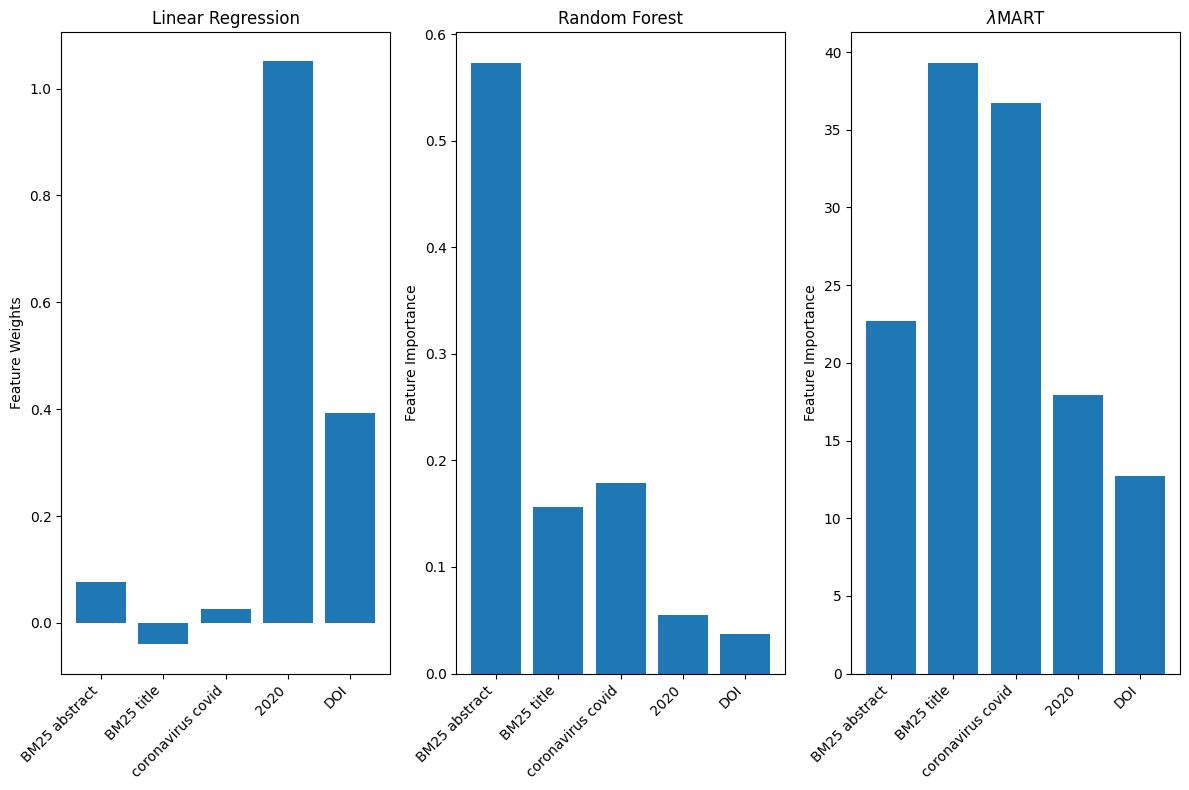

In [68]:
import numpy as np
from matplotlib import pyplot as plt

# Create figure
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 8))

# Plot Linear Regression model weights
ax0.bar(np.arange(len(fnames)), lr.coef_)
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Linear Regression")
ax0.set_ylabel("Feature Weights")
# Plot Random Forest feature importance
ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forest")
ax1.set_ylabel("Feature Importance")
# Plot LmbdaMART feature importance
ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART")
ax2.set_ylabel("Feature Importance")

# Display figure
plt.tight_layout()
plt.show()
